# 0.0 Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from matplotlib import gridspec
from IPython.core.display import HTML
from IPython.display import Image

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 10
    
    display( HTML('<style>.container { width:100% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv('/home/llopomo/repos/ds_producao/data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('/home/llopomo/repos/ds_producao/data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Passo 01 - Descriçao dos Dados

In [4]:
# Security Copy
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval'
            ]

snakecase = lambda x : inflection.underscore(x)
cols_new = list (map (snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimesions 

In [7]:
print(f'Number of rows {df1.shape[0]}')
print(f'Number of columns {df1.shape[1]}')

Number of rows 1017209
Number of columns 18


## 1.3 Data Types 

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA 

### competition_distance
distance in meters to the nearest competitor store

<b>Assumption 1</b> : Podemos assumir que não há lojas competidoras próximas das lojas que apresentam NaN. Com isso podemos preencher essa distância com um número muito maior do que a maior distância

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000 if math.isnan(x) else x)

### CompetitionOpenSince[Month/Year]
gives the approximate year and month of the time the nearest competitor was opened

Neste caso, temos duas possibilidades. A loja não possui competidor próximo ou simplesmente não foi preenchido

<b>Assumption:</b> Temos compartamentos de baixa e alta. Com isso devemos manter essa coluna, pois temos as infos que, se há competição próxima então teremos uma alterção no volume de vendas devido a presença da própria concorrência em volta.
<br>
Teste

In [12]:
df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

### Promo2Since[Year/Week]

É o mesmo caso do preenchimento anterior

In [13]:
df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

### promo_interval 
describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Esse é um pouco mais complicado, a proposta é fazer um split desta lista. Aí se a minha data estiver dentro dessa lista. Consideramos que a promoção está ativa.


In [14]:
month_map = {1: 'Jan',2 : 'Feb',3 : 'Mar',4 : 'Apr',5 : 'May',6 : 'Jun',7 : 'Jul ',8: 'Aug',9: 'Sep',10: 'Oct',11 : 'Nov',12 : 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x : 
    0 if x['promo_interval'] == 0 else
    1 if x['promo_interval'].split(',') else 0, axis=1
)

## 1.6 Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_distance'] = df1['competition_distance'].astype('int')
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int')

## 1.7 Descriptive Statiscal

In [17]:
num_attributes = df1.select_dtypes(include= [ 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude= [ 'int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [18]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispercion - std, min, max, range, skew, curtoses
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x : x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x : x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x : x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4 ,ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['atributtes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,atributtes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


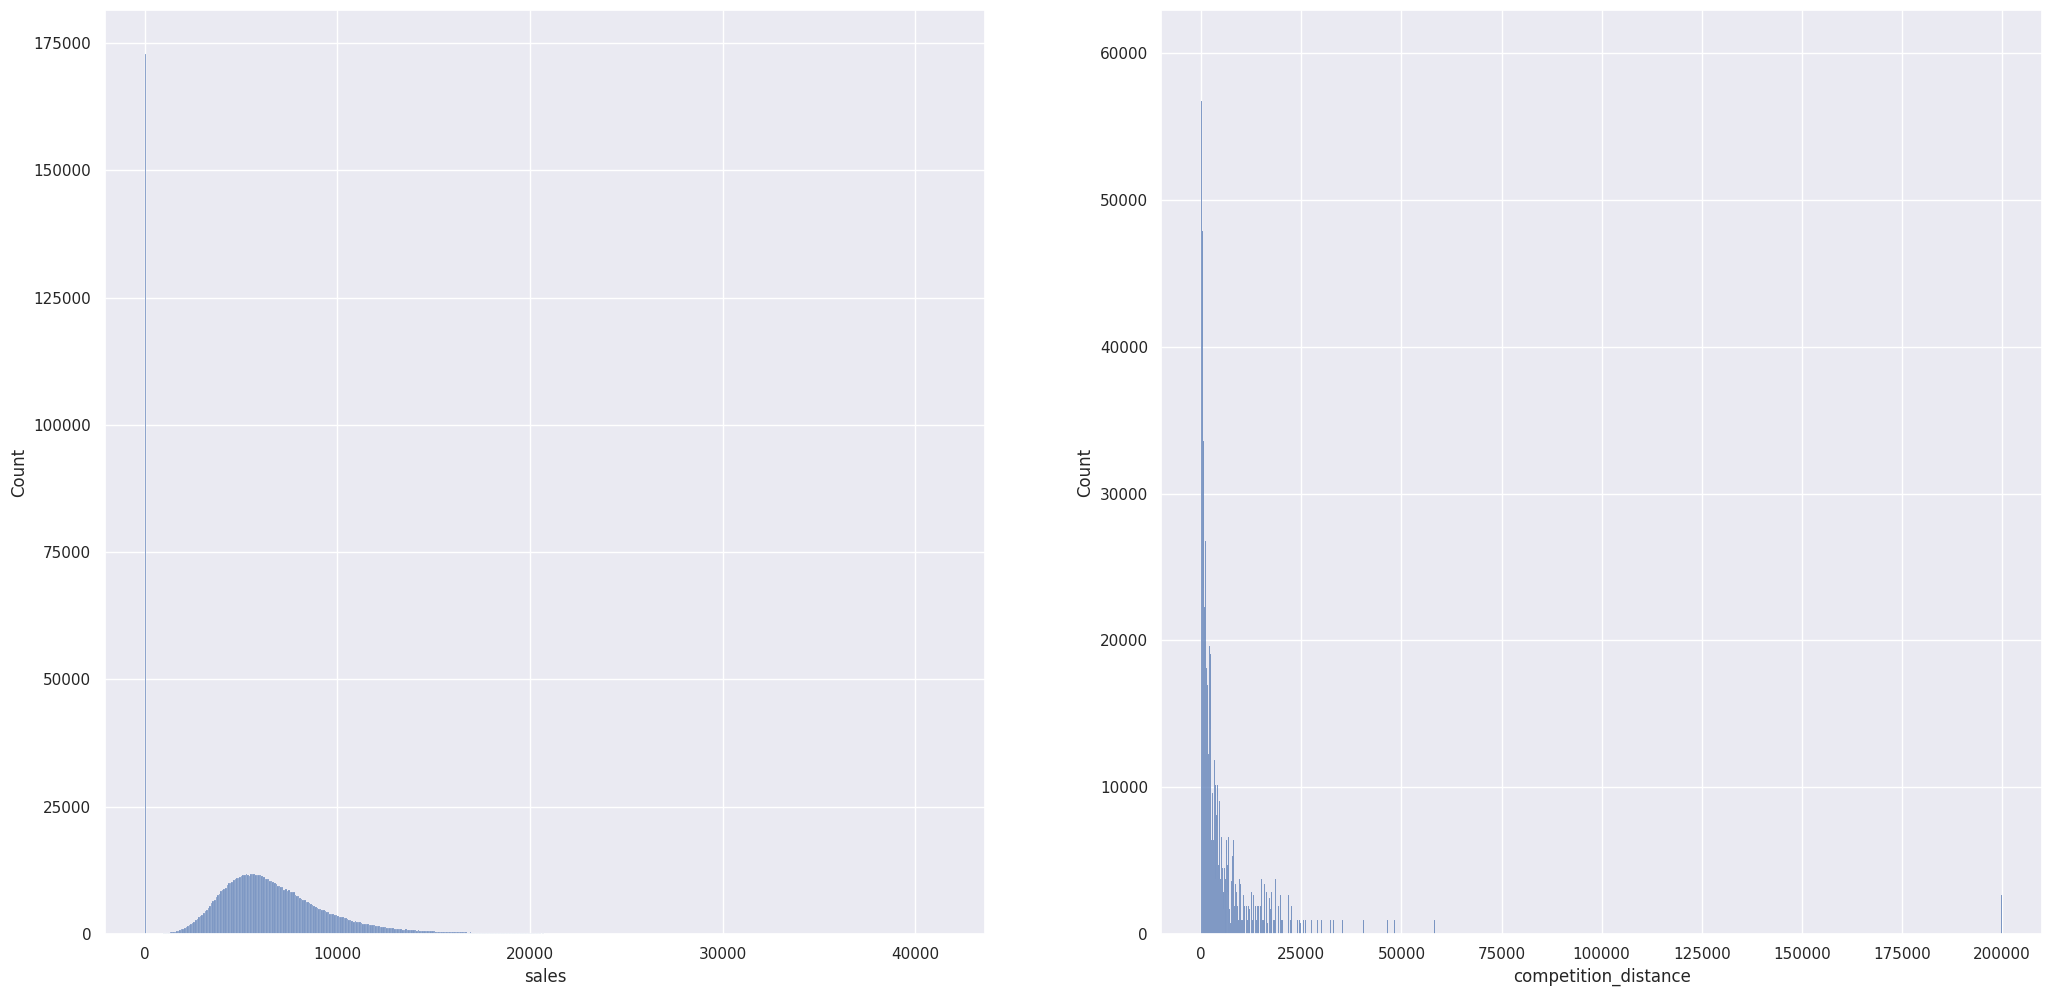

In [19]:
plt.subplot(1,2,1)
sns.histplot( df1['sales'], kde=False )
plt.subplot(1,2,2)
sns.histplot( df1['competition_distance'], kde=False );

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x : x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

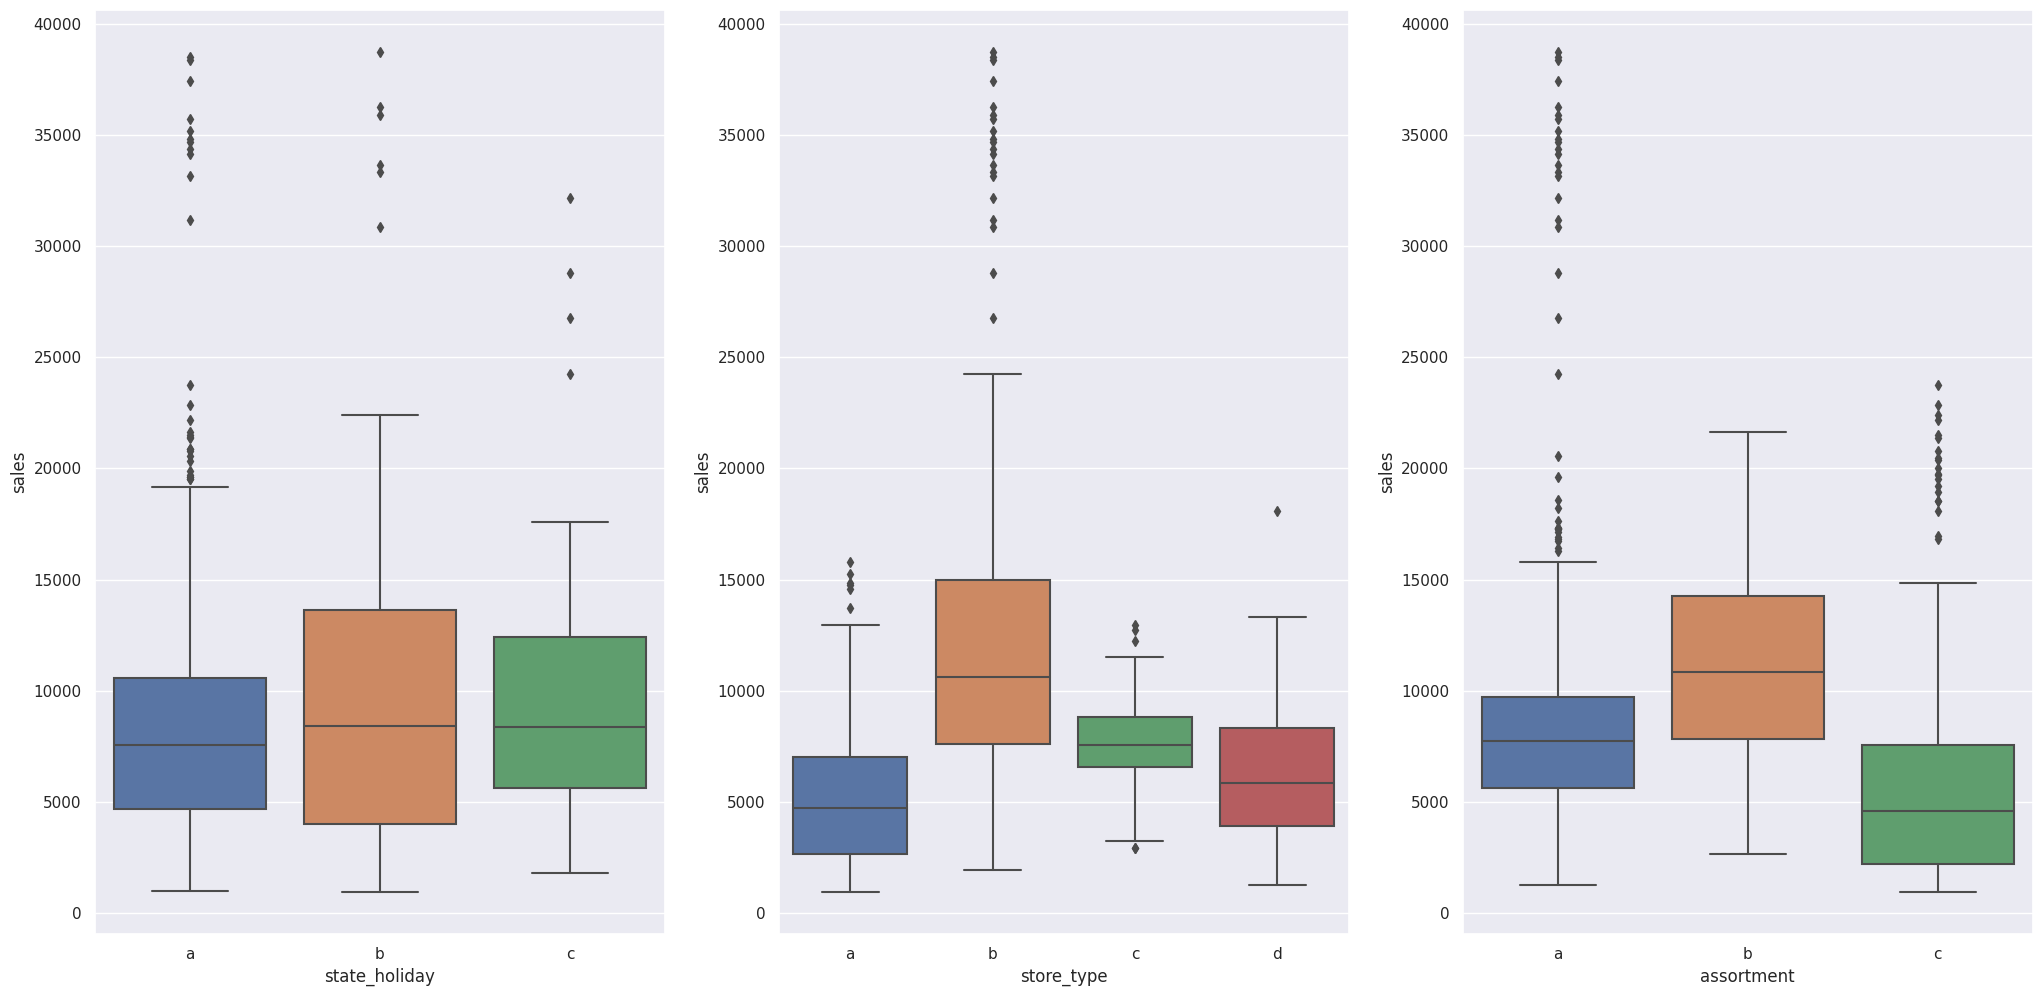

In [21]:
df_tempo = df1.loc[(df1['state_holiday']!= "0" ) & (df1['sales']> 0) ]


plt.subplot(1,3,1)
df_tempo = df_tempo.sort_values(by='state_holiday', ascending=True)
sns.boxplot(data=df_tempo, x='state_holiday', y = 'sales')

plt.subplot(1,3,2)
df_tempo = df_tempo.sort_values(by='store_type', ascending=True)
sns.boxplot(data=df_tempo, x='store_type', y = 'sales')

plt.subplot(1,3,3)
df_tempo = df_tempo.sort_values(by='assortment', ascending=True)
sns.boxplot(data=df_tempo, x='assortment', y = 'sales')

# 2.0 Passo 02 - Feature Engineering

## 2.1 Mapa mental de Hipóteses

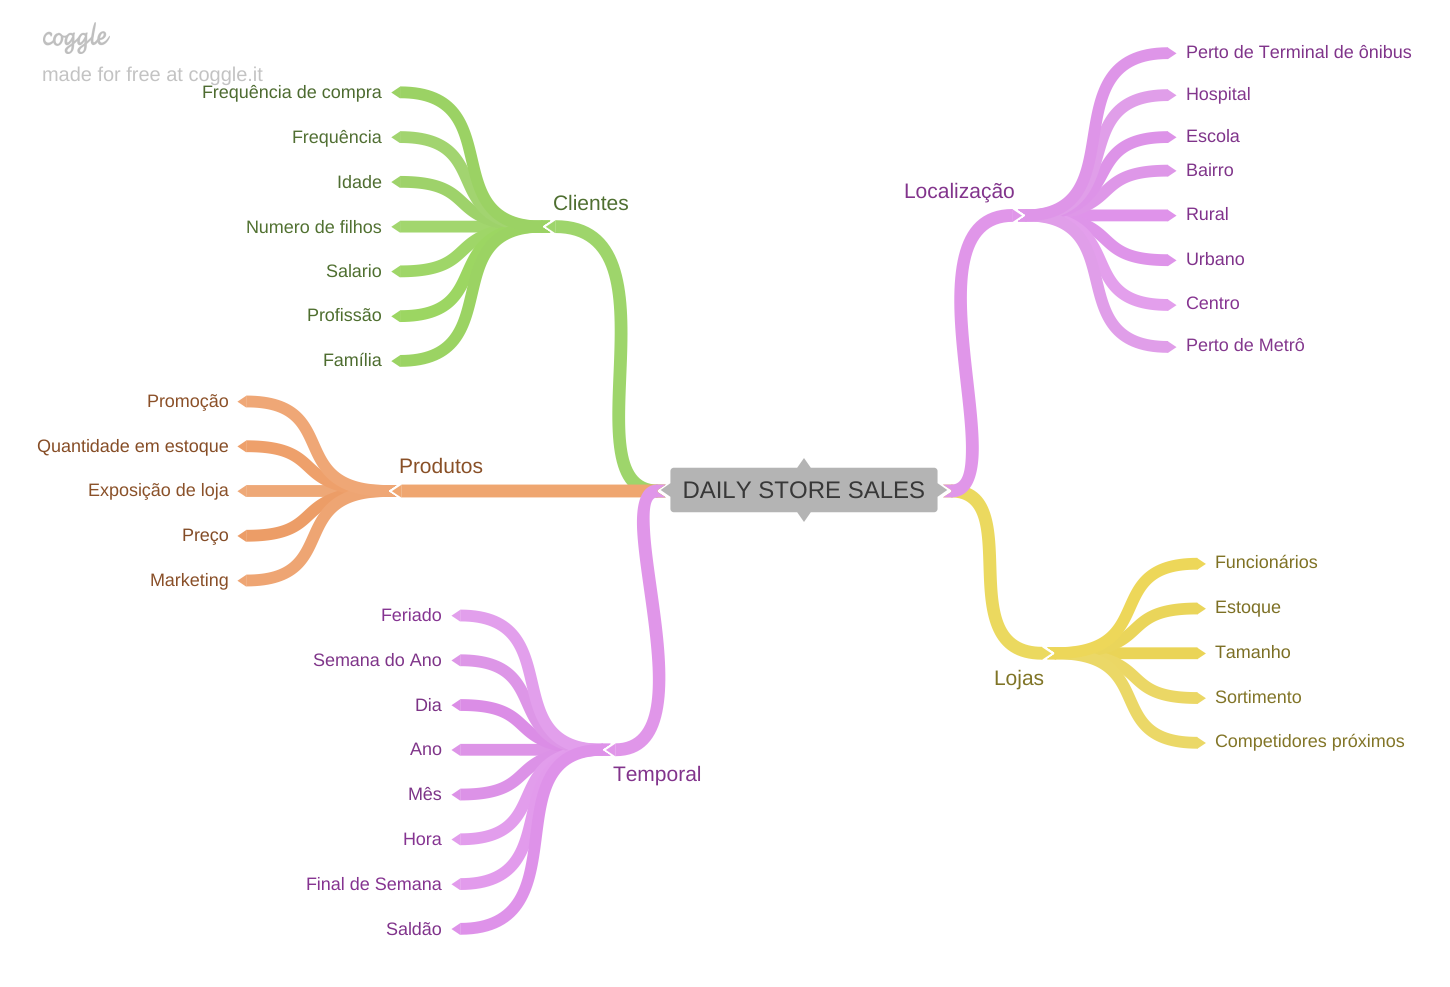

In [22]:
Image('/home/llopomo/repos/ds_producao/img/mind_map_hipoteses.png')

## 2.2 Criação das Hipóteses

### 2.2.1 - Hipóteses Relacionadas a Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor estoque deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

### 2.2.2 - Hipóteses do Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo deveriam vender mais.

### 2.2.3 - Hipóteses Relacionadas a Tempo

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros seis meses deveriam vender mais.

**3.** Lojas que abrem nos final de semana deveriam vender mais.

### 2.2.4 Lista final de Hipóteses

**1.** - Lojas com maior sortimentos devem vender mais.

**2.** - Lojas com competidores mais próximos devem vender menos.

**3.** - Lojas com competidores à mais tempo deveriam vender mais.

**4.** - Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** - Lojas com mais promoções deveriam vender mais

**6.** - Lojas com mais promoções conscecutivas deveriam vender mais.

**7.** - Lojas abertas durante o feriado deveriam vender mais.

**8.** - Lojas deveriam vender mais ao longo dos anos.

**9.** - Lojas deveriam vender mais no segundo semestre do ano.

**10.** - Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** - Lojas deveriam vender menos aos finais de semana

**12.** - Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

In [23]:
df2 = df1.copy()

In [24]:
# assorment
df2['assortment'] = df2['assortment'].apply(lambda x: 
    'basic' if x == 'a' else
    'extra' if x == 'b' else
    'extended'
)
# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 
    'public_holiday' if x == 'a' else
    'easter_holiday' if x == 'b' else
    'christmas' if x == 'c' else
    'regular_day'
)

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(int)

# year week
df2['week_year'] = df2['date'].dt.strftime('%Y-%W')

#competition since and competition_time_month
df2['competition_since'] = df2.apply(lambda x : 
    datetime.datetime(year=x['competition_open_since_year'], 
                      month=x['competition_open_since_month'],
                      day = 1), axis=1
)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/ 30).apply(lambda x: x.days).astype(int)

# promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x : datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'])/ 7).apply(lambda x : x.days).astype(int)


# 3 Passo 03 - Filtragem de variáveis

In [25]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [26]:
# Customers - Variável que eu não tenho disponível no momento da previsão
# Open - Loja aberta tem vendas e lojas fechada é venda 0
# Sales - Excluir as linhas quando houver vendas == 0

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Passo 04 - Análise Exploratória de Dados

## 4.1 Analise Univariada

In [99]:
df4 = df3.copy()

### 4.1.1 Response Variable

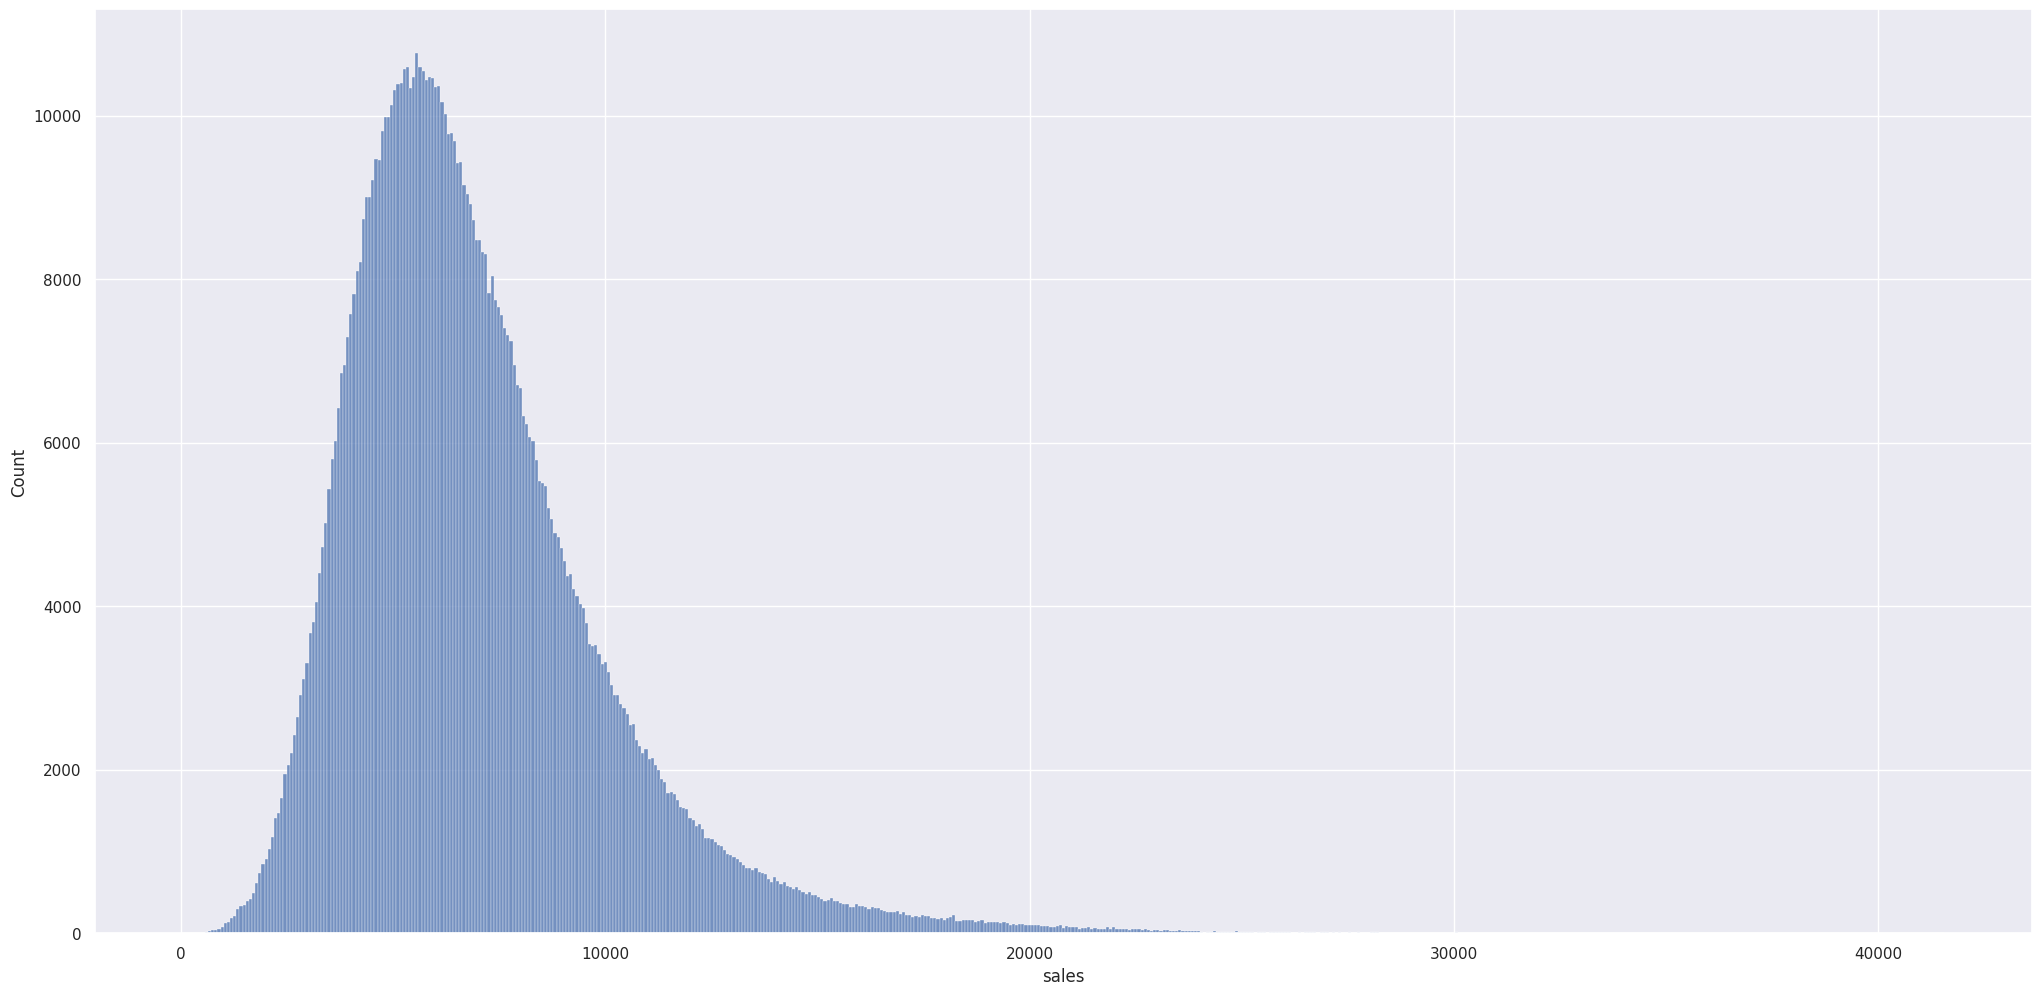

In [100]:
sns.histplot(df4['sales']);

### 4.1.2 Numerical Variable

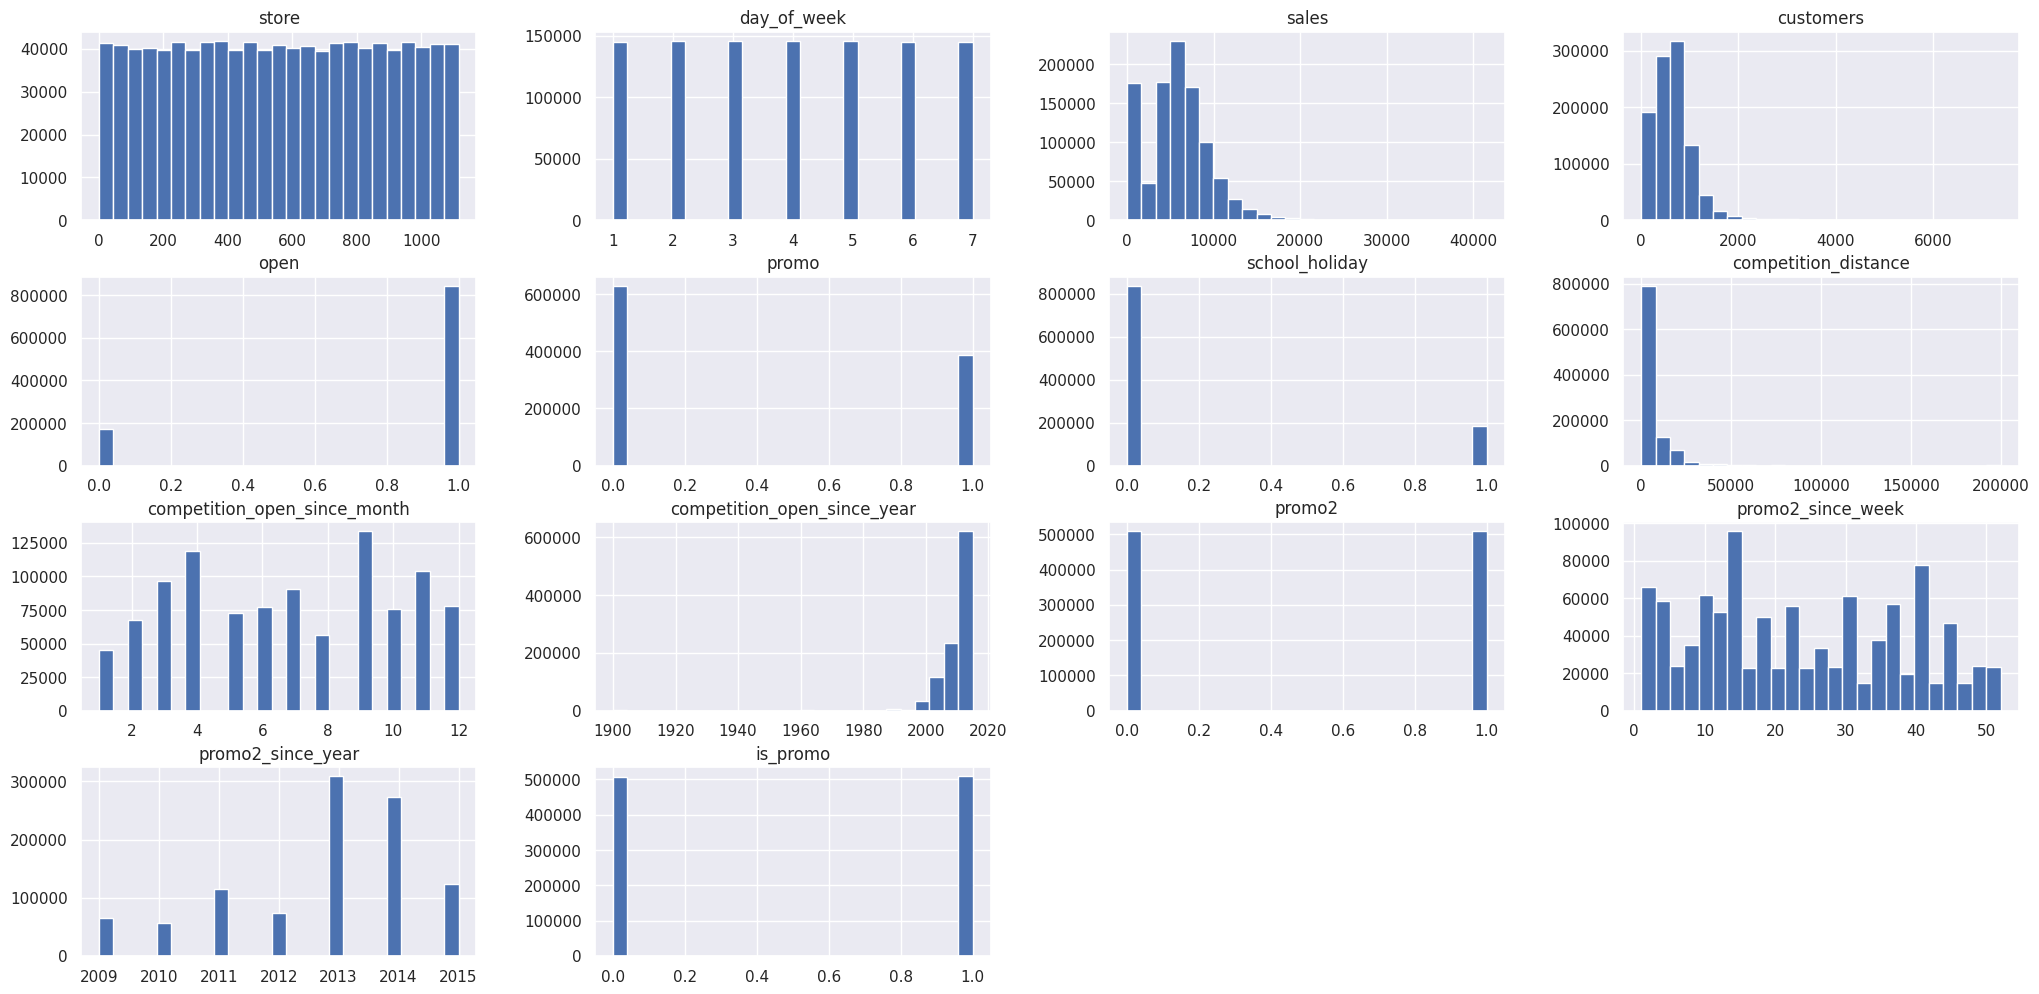

In [101]:
num_attributes.hist(bins=25); 

### 4.1.3 Categorical Variable

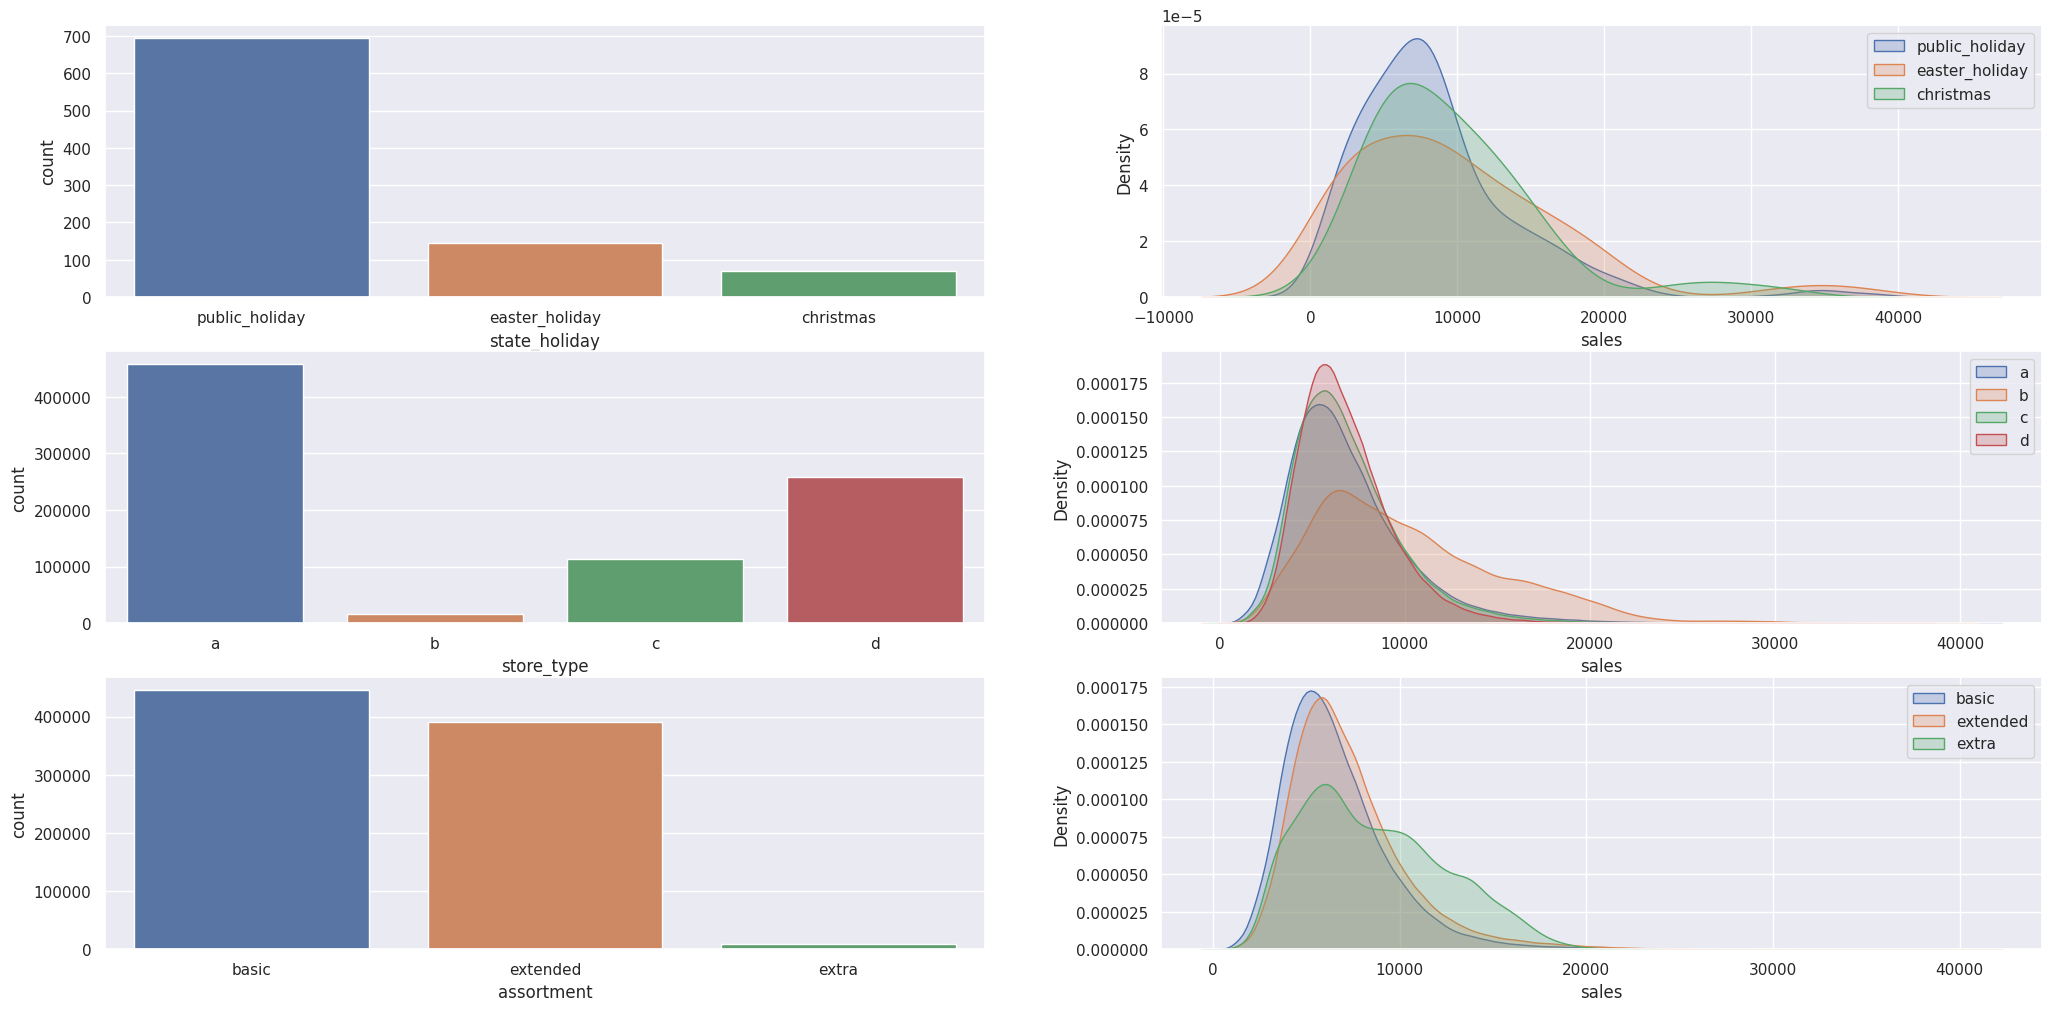

In [102]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(data=df4[df4['state_holiday'] == 'public_holiday']['sales'], fill=True, legend=True, label='public_holiday')
sns.kdeplot(data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], fill=True, legend=True, label='easter_holiday')
sns.kdeplot(data=df4[df4['state_holiday'] == 'christmas']['sales'], fill=True, legend=True, label='christmas')
plt.legend()

# store_type
df4 = df4.sort_values('store_type')
plt.subplot(3,2,3)
sns.countplot(x=df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(data=df4[df4['store_type'] == 'a']['sales'], fill=True, legend=True, label='a')
sns.kdeplot(data=df4[df4['store_type'] == 'b']['sales'], fill=True, legend=True, label='b')
sns.kdeplot(data=df4[df4['store_type'] == 'c']['sales'], fill=True, legend=True, label='c')
sns.kdeplot(data=df4[df4['store_type'] == 'd']['sales'], fill=True, legend=True, label='d')
plt.legend()


# assortment
plt.subplot(3,2,5)
sns.countplot(x=df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(data=df4[df4['assortment'] == 'basic']['sales'], fill=True, legend=True, label='basic')
sns.kdeplot(data=df4[df4['assortment'] == 'extended']['sales'], fill=True, legend=True, label='extended')
sns.kdeplot(data=df4[df4['assortment'] == 'extra']['sales'], fill=True, legend=True, label='extra')
plt.legend()


## 4.2 Analise Bivariada

### **1.** - Lojas com maior sortimentos devem vender mais.

<AxesSubplot: xlabel='week_year'>

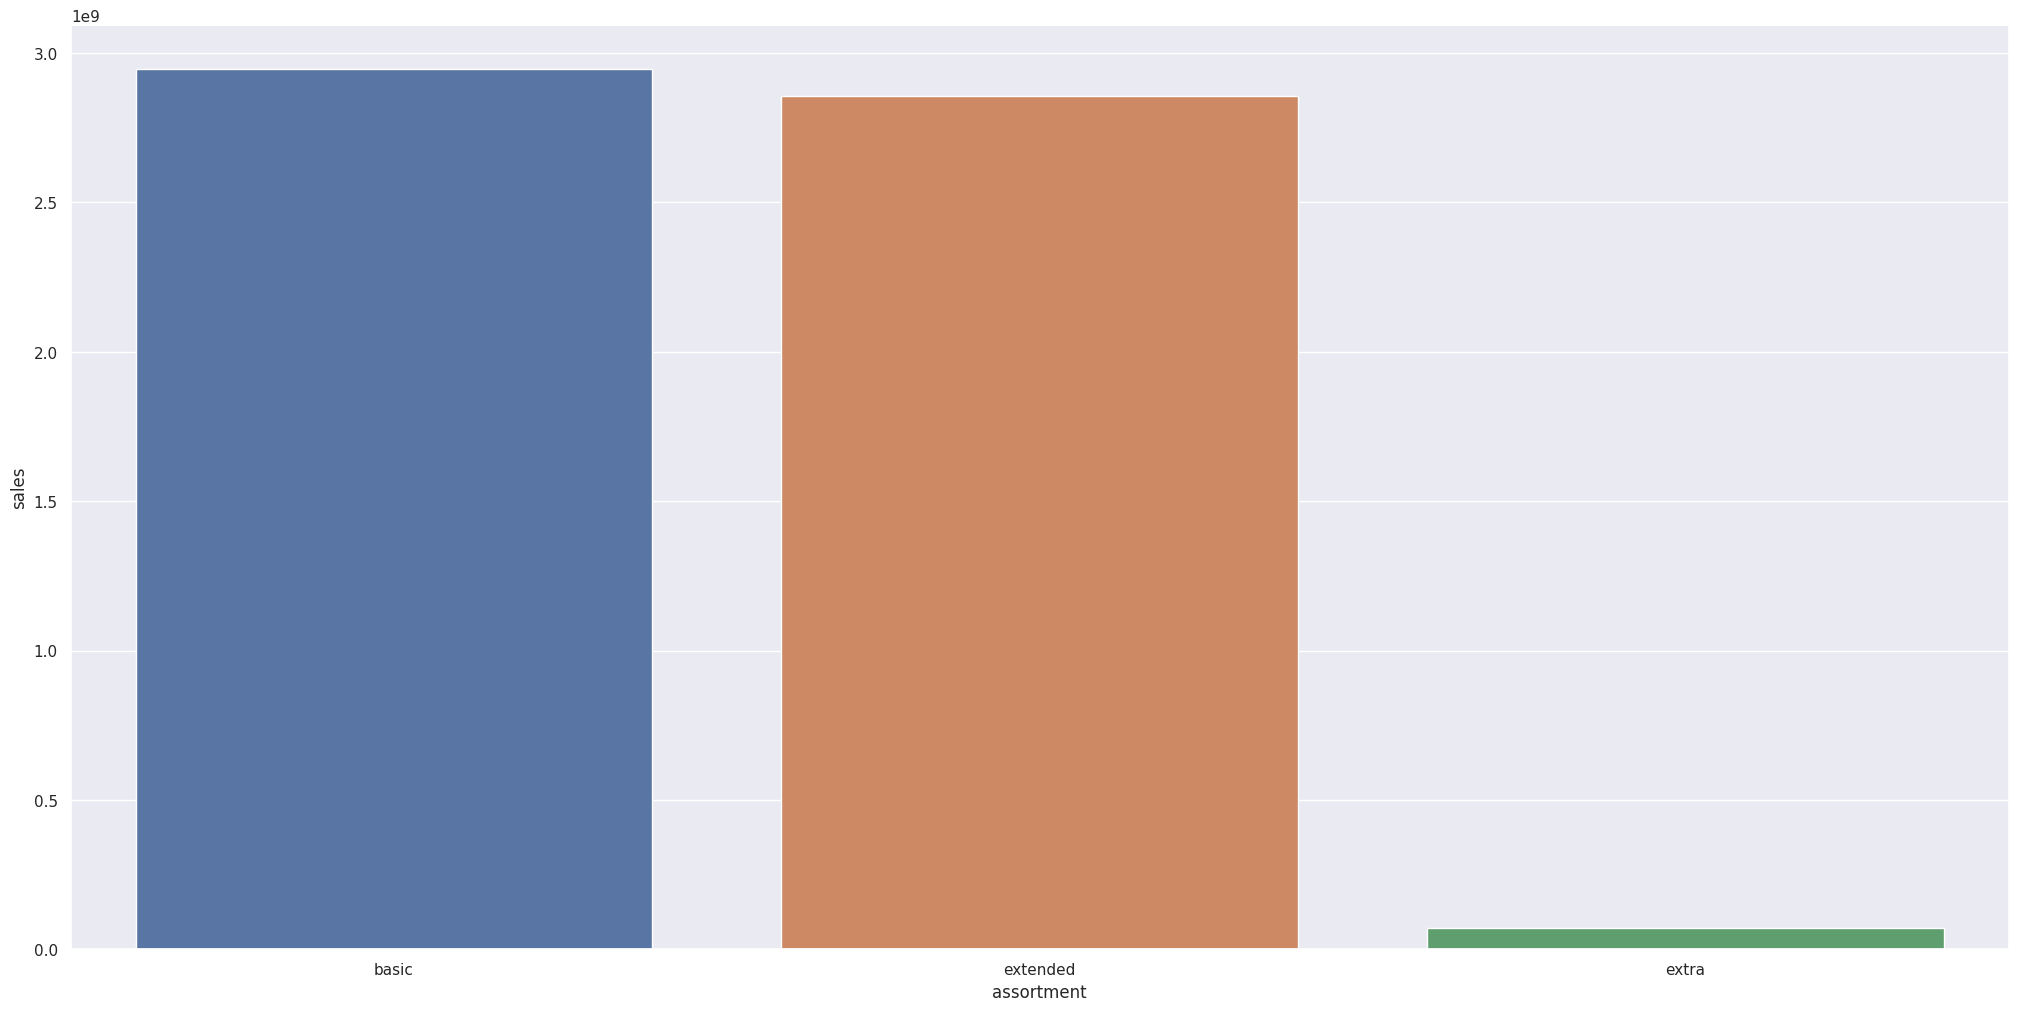

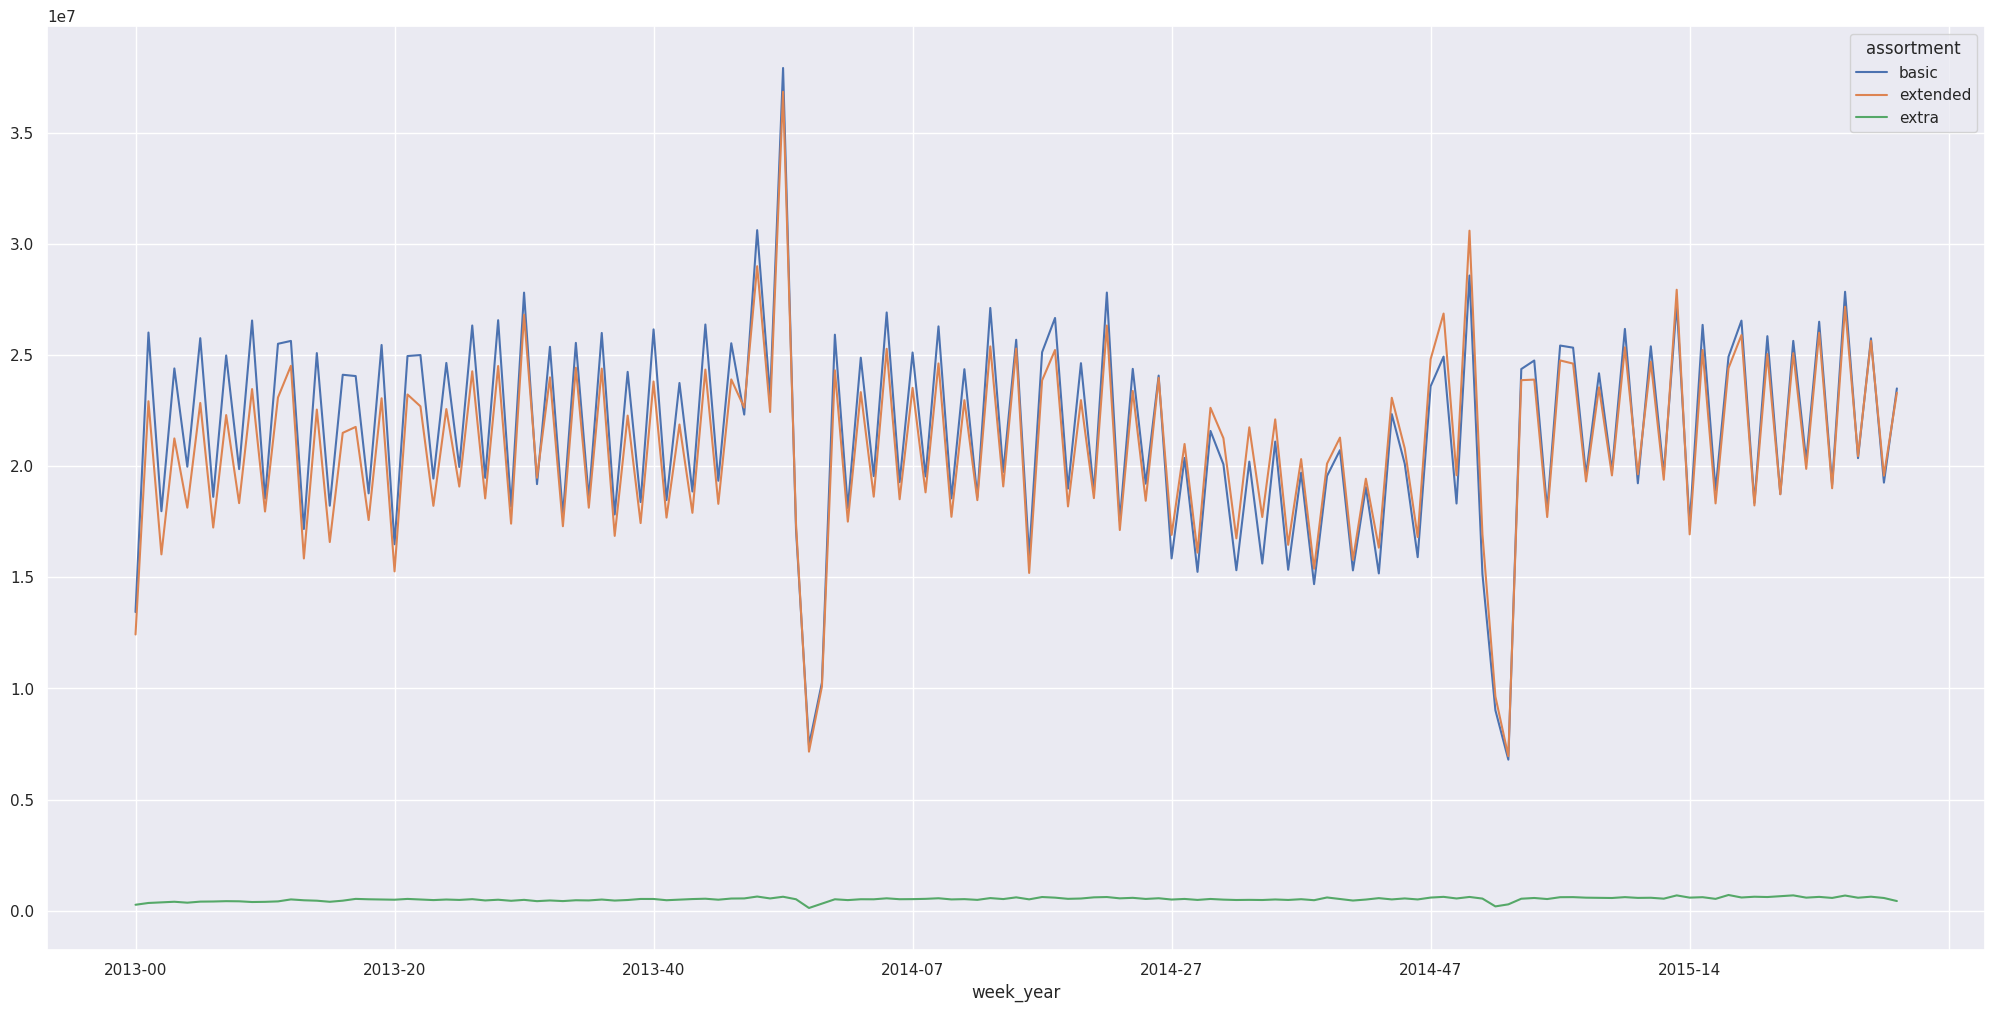

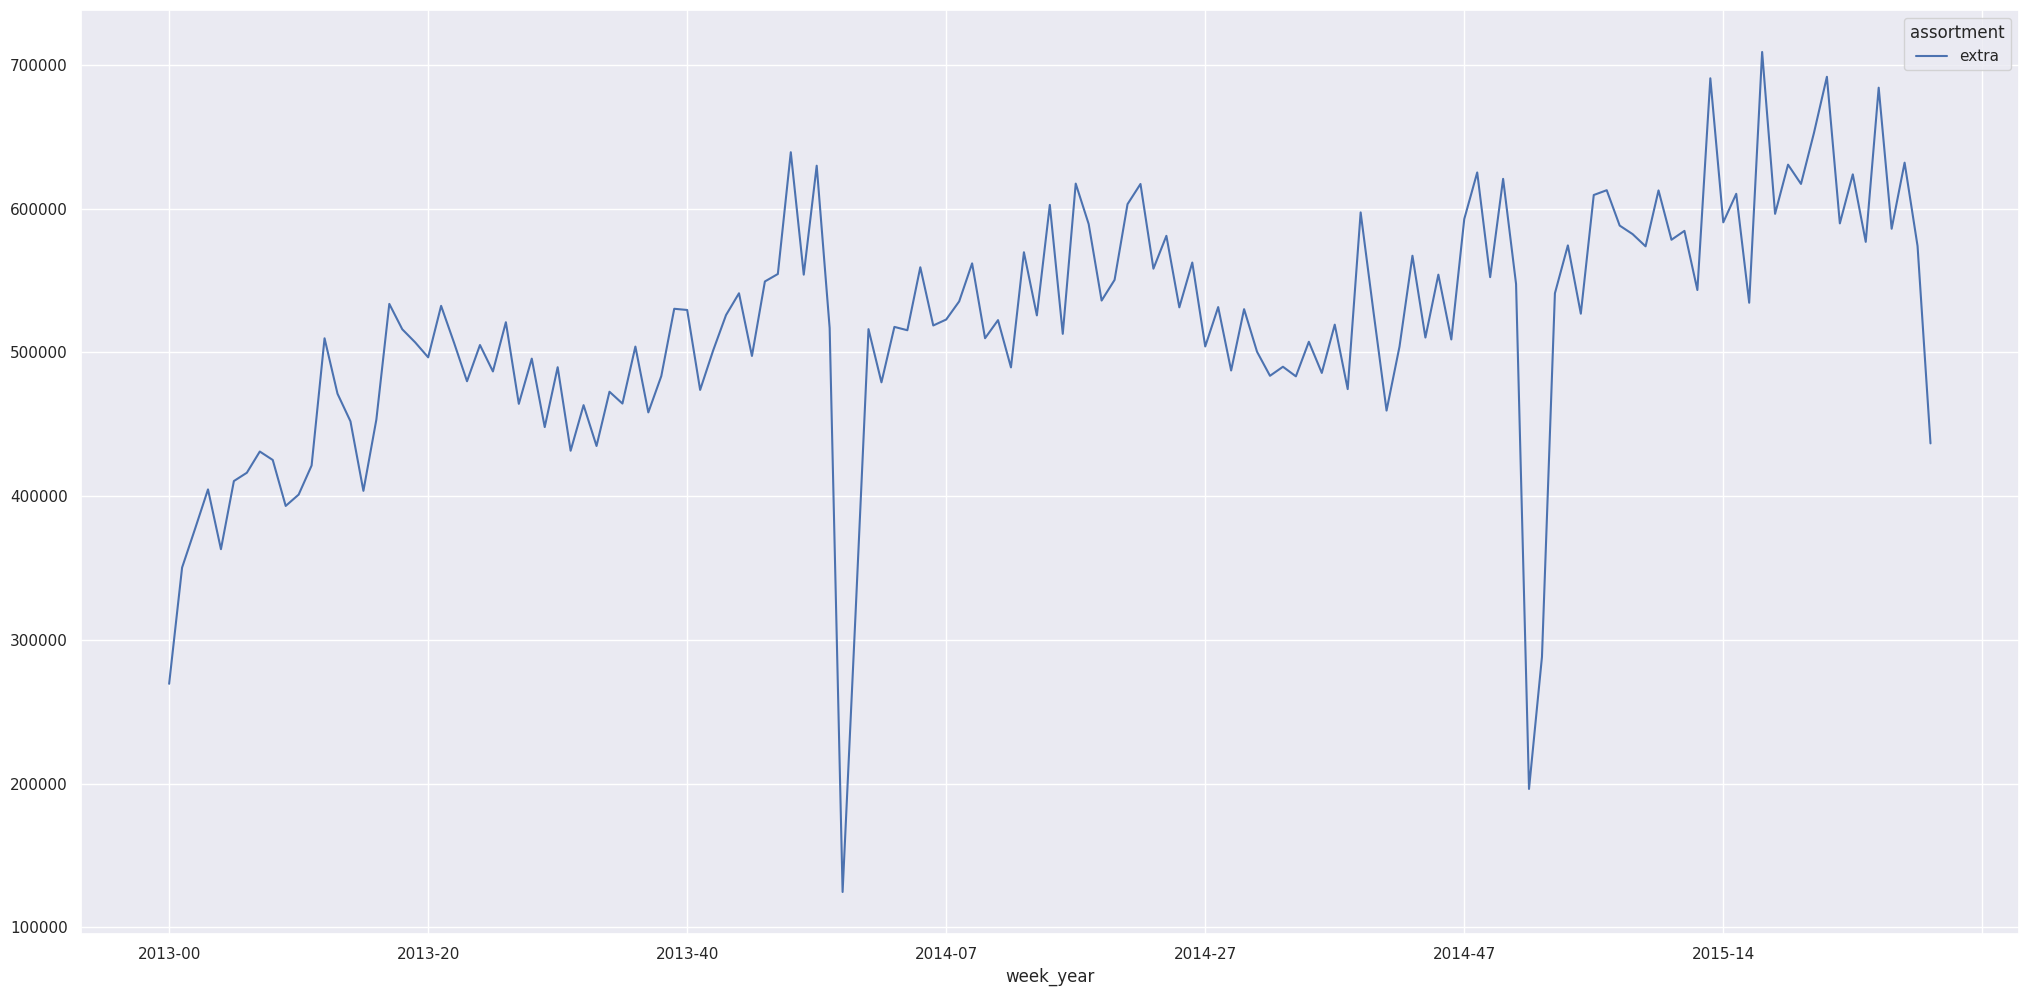

In [103]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x= 'assortment', y='sales', data=aux1)

aux2 = df4[['week_year', 'assortment', 'sales']].groupby(['week_year','assortment']).sum().reset_index().pivot(index = 'week_year', columns='assortment', values='sales')
aux2.plot()

aux3 = df4[df4['assortment'] == 'extra']
aux3 = aux3[['week_year', 'assortment', 'sales']].groupby(['week_year','assortment']).sum().reset_index().pivot(index = 'week_year', columns='assortment', values='sales')
aux3.plot()

**Falso, Lojas com maior sortimento vendem menos.**

### **2.** - Lojas com competidores mais próximos devem vender menos.

/tmp/ipykernel_10464/889866051.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True)


<AxesSubplot: >

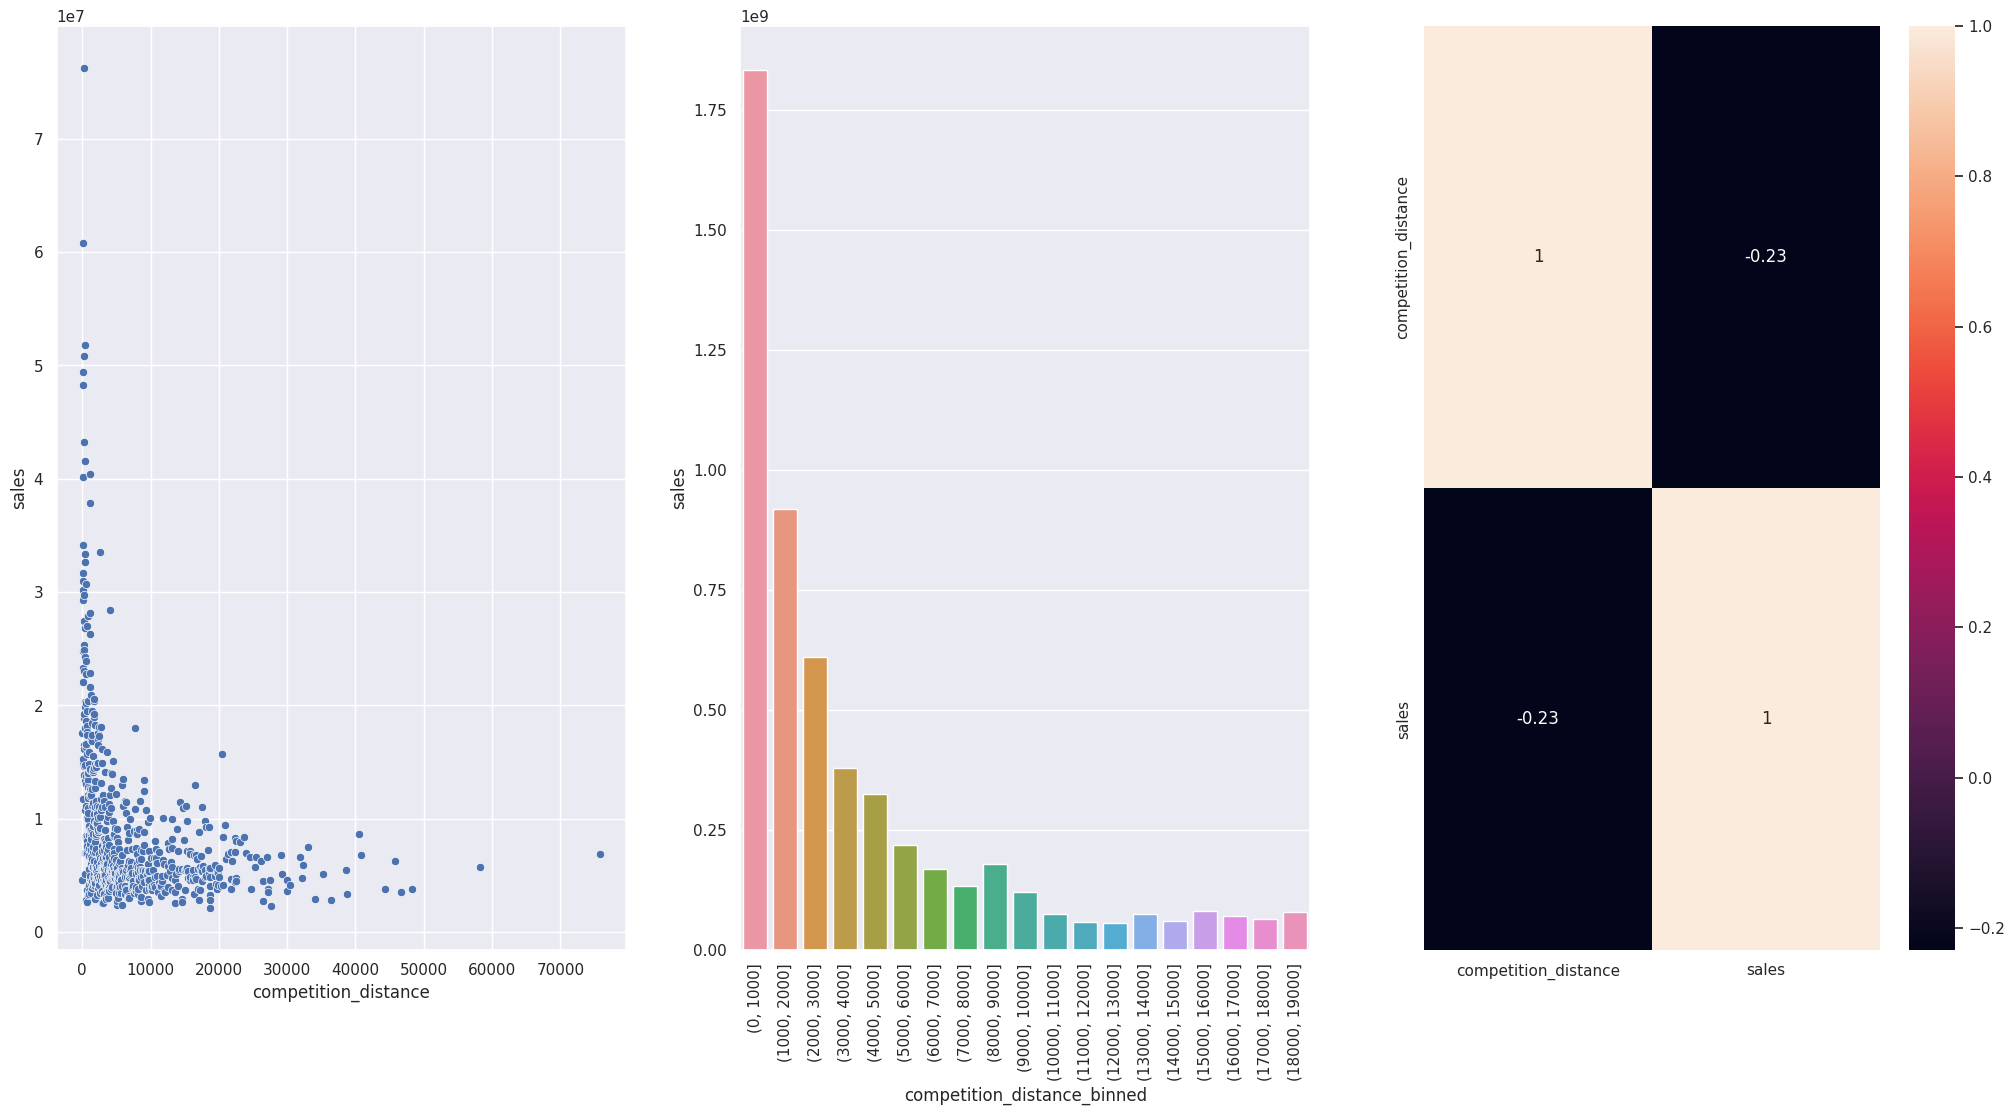

In [104]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

plt.subplot(1,3,1)
sns.scatterplot(data=aux1[aux1['competition_distance'] != 200000] , x= 'competition_distance', y='sales');

plt.subplot(1,3,2)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

**FALSO : Quanto mais próximo os competidores maior é o número de vendas**

### **3.** - Lojas com competidores à mais tempo deveriam vender mais.

<AxesSubplot: >

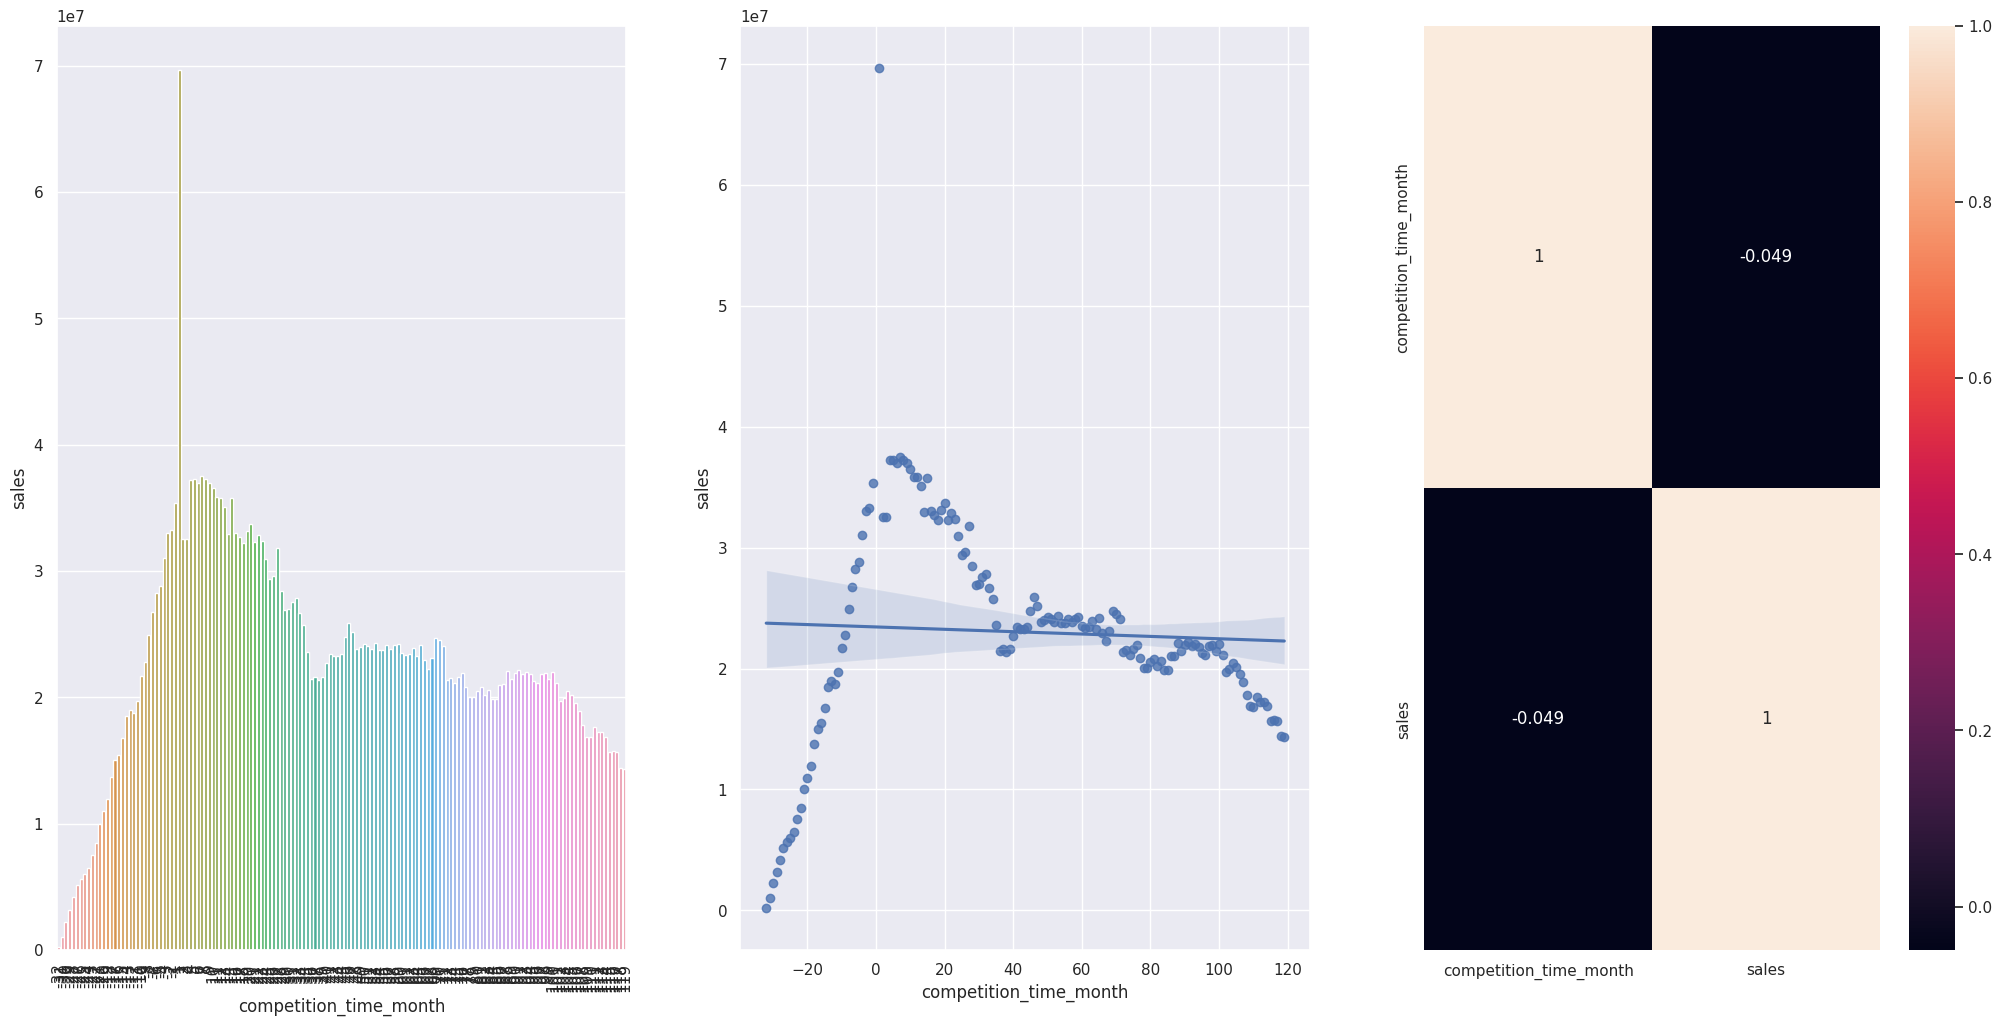

In [111]:

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y= 'sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data = aux2)

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True)

**FALSO Lojas com competidores abertos a mais tempo vendem MENOS**

## 4.3 Analise Multivariada